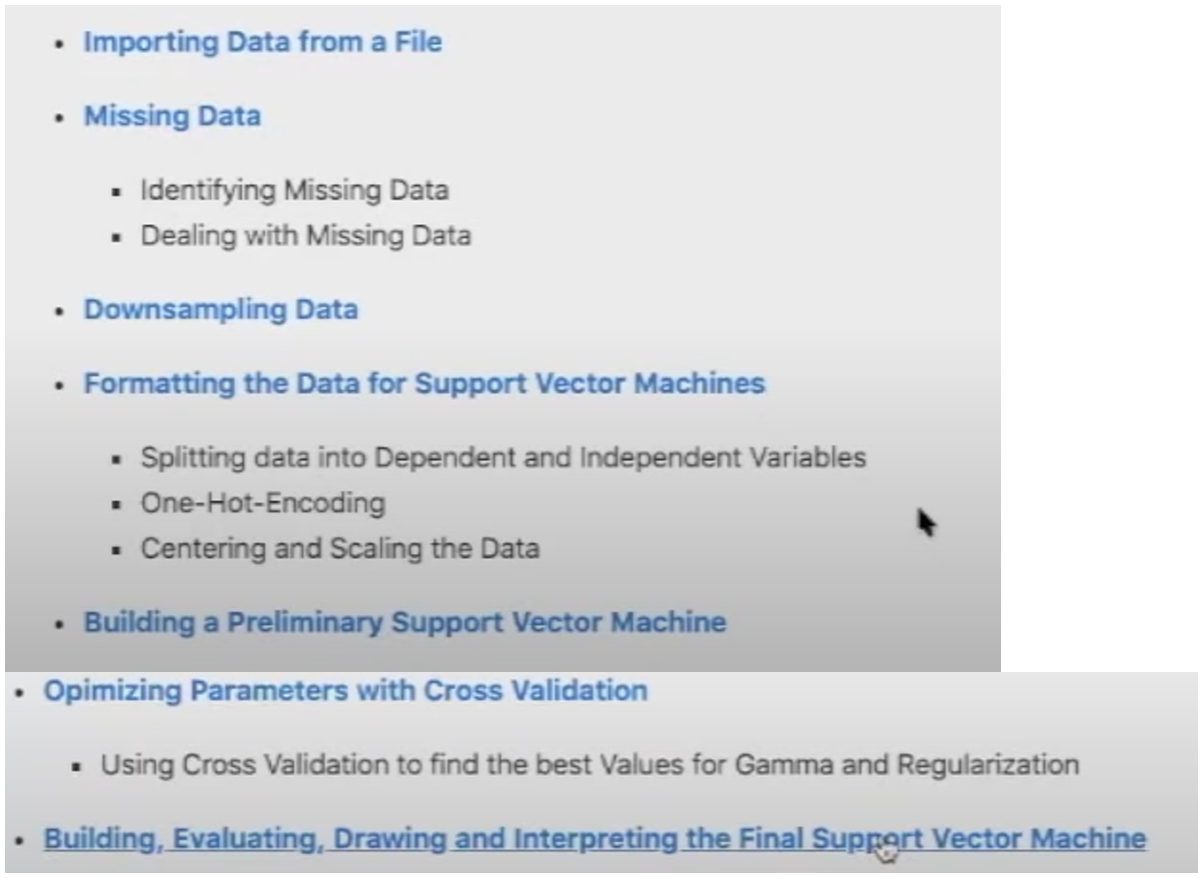


In [1]:
import pandas as pd #used to load and manipulate data for one hot encoding
import numpy as np #data manipulation
import matplotlib.pyplot as plt # for drawing graphs
import matplotlib.colors as colors

# time to import sklearn packages

In [2]:
from sklearn.utils import resample #downsample the dataset
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import scale #scale and centre data
from sklearn.svm import SVC # this will make a support vector machine for classification
from sklearn.model_selection import GridSearchCV #this will do cross validation
from sklearn.metrics import confusion_matrix #creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws the created confusion matrix
from sklearn.decomposition import PCA #perform PCA to plot the data

In [3]:
df=pd.read_csv("C:\\Users\\Utkarsh\\Downloads\\default of credit card clients.csv")

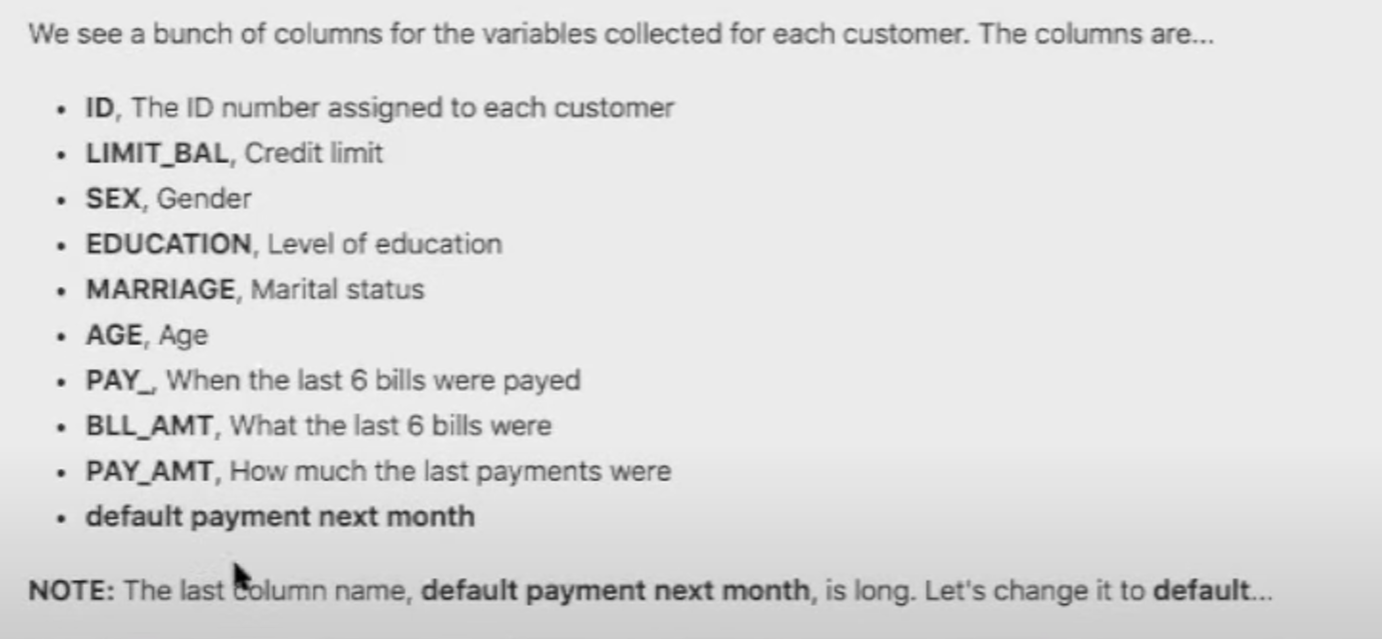

In [4]:
df.rename({'default payment next month':'DEFAULT'}, axis='columns', inplace=True)

In [5]:
df.drop('ID',axis=1, inplace=True)

# Time to deal with missing data.

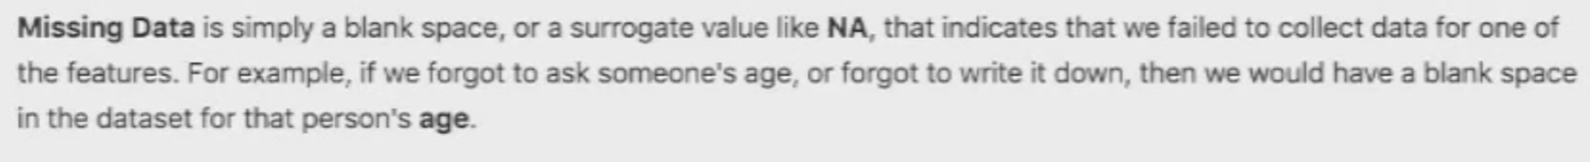

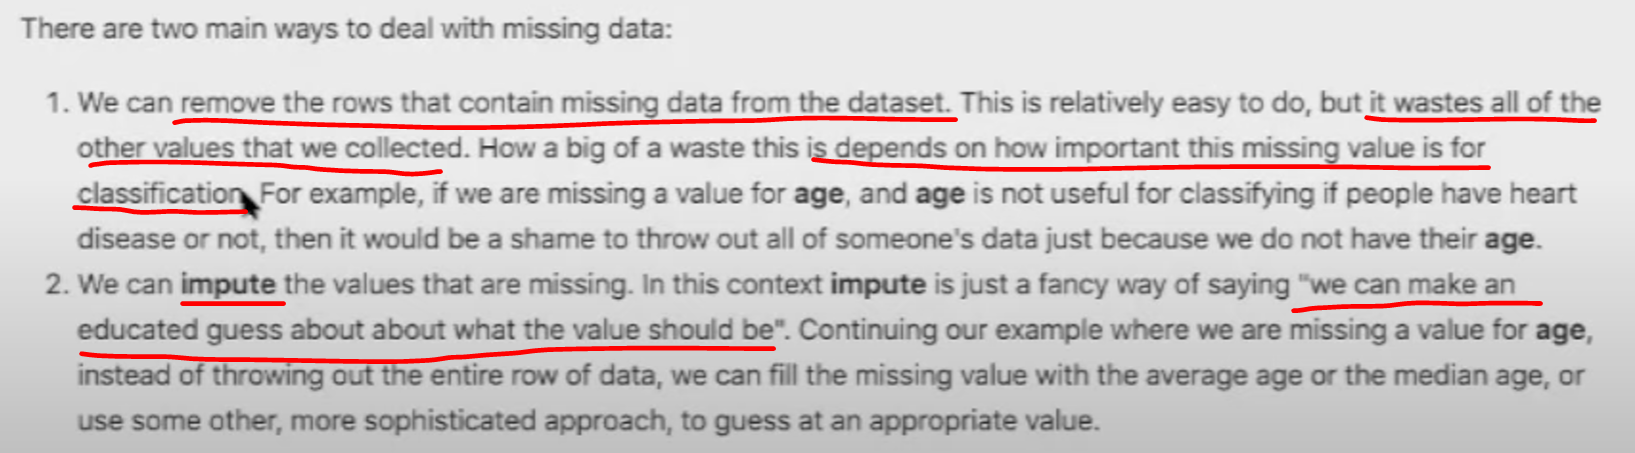

Let's check the type of data in each column.

In [6]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

Its all int64 so we know they haven't mixed numbers and alphabets.

We should still check what values are allowed in each column. 
The data regarding column values has been obtained from data source site

**Amount of the given credit (NT dollar)**: it includes both the individual consumer credit and his/her family (supplementary) credit.

**Gender** (1 = male; 2 = female).

**Education** (1 = graduate school; 2 = university; 3 = high school; 4 = others).

**Marital status** (1 = married; 2 = single; 3 = others).

**Age** (year).

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    X6 = the repayment status in September, 2005; 
    X7 = the repayment status in August, 2005; . . .;
    X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.


# Now we'll check if the data matches the desciption

In [7]:
df["SEX"].unique()

array([2, 1], dtype=int64)

Sex is as described

In [8]:
df["EDUCATION"].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

0, 5, 6 values are not in the description but still here.

In [9]:
df["MARRIAGE"].unique()

array([1, 2, 3, 0], dtype=int64)

zero might mean data is missing

# Dealing with mising data part 2

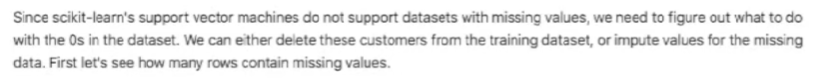

In [10]:
len(df.loc[(df['EDUCATION']==0) | (df['MARRIAGE']==0)])

68

SO 14 rows have information missing

In [11]:
len(df)

30000

The percentage of items with missng info is less than 1 %, so we can ignore them.
There is no need to impute data here.

In [12]:
df_no_missing = df.loc[~((df['EDUCATION']==0) | (df['MARRIAGE']==0))]

In [13]:
len(df_no_missing)

29932

Length is as expectd after removing blank values.

Now, lets check unique values.

In [14]:
df_no_missing['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6], dtype=int64)

In [15]:
df_no_missing['MARRIAGE'].unique()

array([1, 2, 3], dtype=int64)

# Now we downsample the data

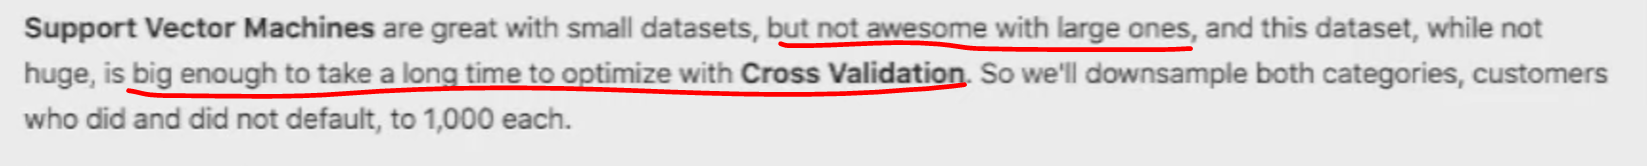

First separate datasets into two groups, those who defaulted and those who didn't.

In [16]:
df_no_default= df_no_missing[df_no_missing["DEFAULT"]==0]
df_default= df_no_missing[df_no_missing["DEFAULT"]==1]

In [17]:
df_no_default_downsampled = resample(df_no_default,
                                    replace=False, #so that the same item is not picked again from the source dataset
                                     n_samples=1000,
                                     random_state=42) 
'''quantifying randomcy so that two people with the same dataset and random state get the same output'''

'quantifying randomcy so that two people with the same dataset and random state get the same output'

In [18]:
df_default_downsampled = resample(df_default,
                                    replace=False, #so that the same item is not picked again from the source dataset
                                     n_samples=1000,
                                     random_state=42) 
'''quantifying randomcy so that two people with the same dataset and random state get the same output'''

'quantifying randomcy so that two people with the same dataset and random state get the same output'

Now lets merge the two the two dataframes

In [19]:
df_downsample= pd.concat([df_no_default_downsampled, df_default_downsampled])

In [20]:
len(df_downsample)

2000

# Format data part 1: Classify into dependent and independent vaiables

Now we prepare the data for Support Vector Machines:

Separate into:
- Features: columns of data we want to use to make classifications
- Label: columns of we want to predict

NOTE: We removed the empty space so that we have features and labels, every featue rows dorresponds porperly to a label.

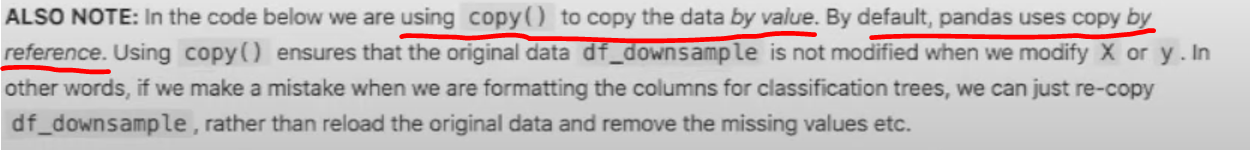

In [21]:
#Features
X= df_downsample.drop('DEFAULT', axis=1).copy()
X.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
641       130000    2          3         1   28      0      0      0      0   
4678      170000    1          3         1   29      0      0      0      0   
16004     180000    2          2         1   29      0      0      0      0   
22974     210000    2          2         2   32     -2     -2     -2     -2   
17535     190000    2          3         1   45      0      0      0      0   

       PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
641       -2  ...      50000          0          0          0      2500   
4678       0  ...     172307      35234      32869      33862      7200   
16004      0  ...      26310      26662      26166      26176      1800   
22974     -2  ...        410          0          0          0       979   
17535      0  ...      80548      81778      83082      84811      3300   

       PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
641        1000         0         0         0         0  
4678       7500      1200      1200      1500      1300  
16004      1800      1500      1056       950      1000  
22974       412         0         0         0         0  
17535      3331      3359      2663      2751      3000  

[5 rows x 23 columns]

In [22]:
#labels
y = df_downsample['DEFAULT'].copy()

Now that features and labels are separated, we can focus on formatting the features.

# Format the data part 2: One hot encoding

# About the data

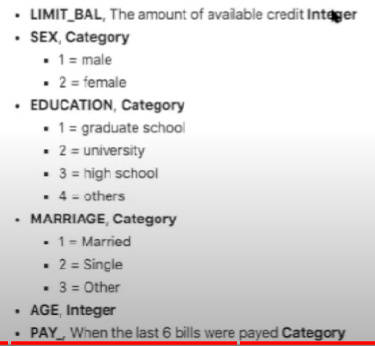
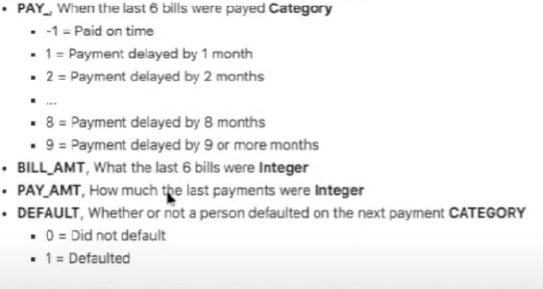

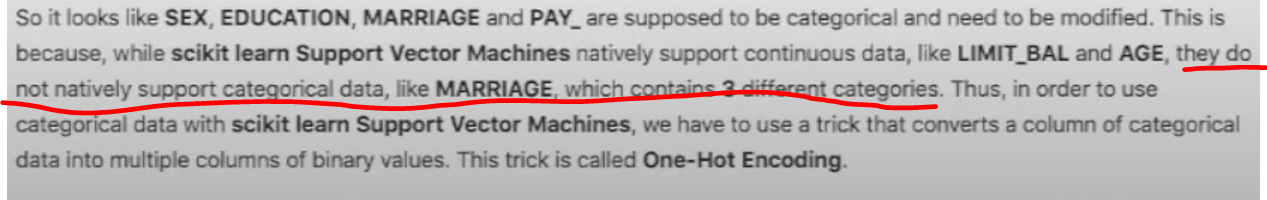

# What if we don't treat the categorical values?

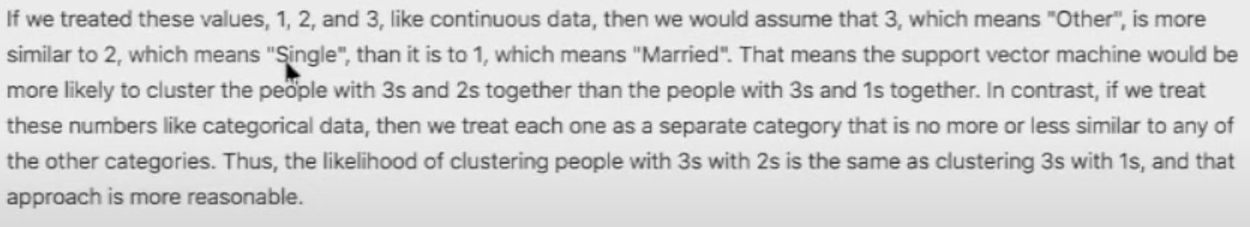

## One hot encoding functions
### Chossing between ColumnTransformer() and get_dummies()

-> get_dummies() better for teaching as it retains the column names and columnvalues

-> ColumnTransformer() is better for production as it is more robust adn handles anomalies better.

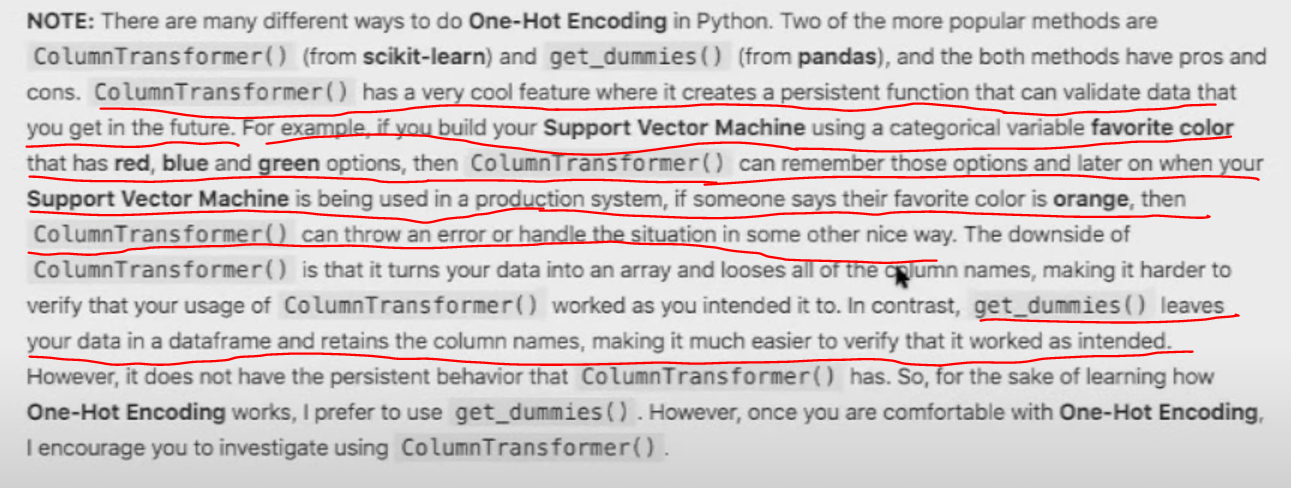

In [23]:
## Lets see what get_dummies() does.

pd.get_dummies(X, columns=["MARRIAGE"]).head()

LIMIT_BAL  SEX  EDUCATION  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  \
641       130000    2          3   28      0      0      0      0     -2   
4678      170000    1          3   29      0      0      0      0      0   
16004     180000    2          2   29      0      0      0      0      0   
22974     210000    2          2   32     -2     -2     -2     -2     -2   
17535     190000    2          3   45      0      0      0      0      0   

       PAY_6  ...  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  \
641       -2  ...          0      2500      1000         0         0   
4678       0  ...      33862      7200      7500      1200      1200   
16004      0  ...      26176      1800      1800      1500      1056   
22974     -2  ...          0       979       412         0         0   
17535      0  ...      84811      3300      3331      3359      2663   

       PAY_AMT5  PAY_AMT6  MARRIAGE_1  MARRIAGE_2  MARRIAGE_3  
641           0         0           1           0           0  
4678       1500      1300           1           0           0  
16004       950      1000           1           0           0  
22974         0         0           0           1           0  
17535      2751      3000           1           0           0  

[5 rows x 25 columns]

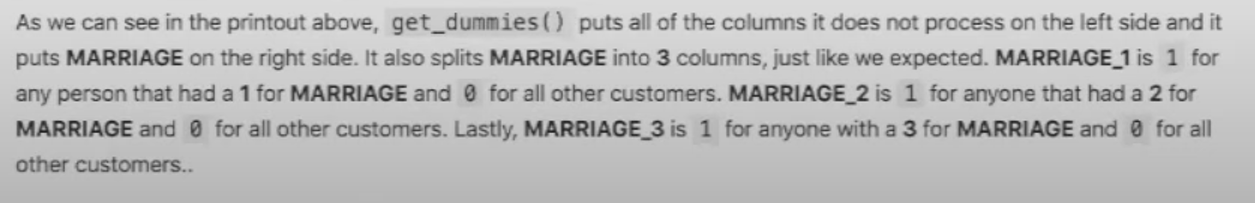

In [24]:
X_encoded= pd.get_dummies(X, columns=["SEX", "EDUCATION","MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"])

X_encoded.head()

LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
641       130000   28     100143      50456      50000          0          0   
4678      170000   29     165027     168990     172307      35234      32869   
16004     180000   29      25781      26000      26310      26662      26166   
22974     210000   32        355        975        410          0          0   
17535     190000   45      76433      78472      80548      81778      83082   

       BILL_AMT6  PAY_AMT1  PAY_AMT2  ...  PAY_5_7  PAY_6_-2  PAY_6_-1  \
641            0      2500      1000  ...        0         1         0   
4678       33862      7200      7500  ...        0         0         0   
16004      26176      1800      1800  ...        0         0         0   
22974          0       979       412  ...        0         1         0   
17535      84811      3300      3331  ...        0         0         0   

       PAY_6_0  PAY_6_2  PAY_6_3  PAY_6_4  PAY_6_5  PAY_6_6  PAY_6_7  
641          0        0        0        0        0        0        0  
4678         1        0        0        0        0        0        0  
16004        1        0        0        0        0        0        0  
22974        0        0        0        0        0        0        0  
17535        1        0        0        0        0        0        0  

[5 rows x 81 columns]

# Format the data part 3: Centering and scaling

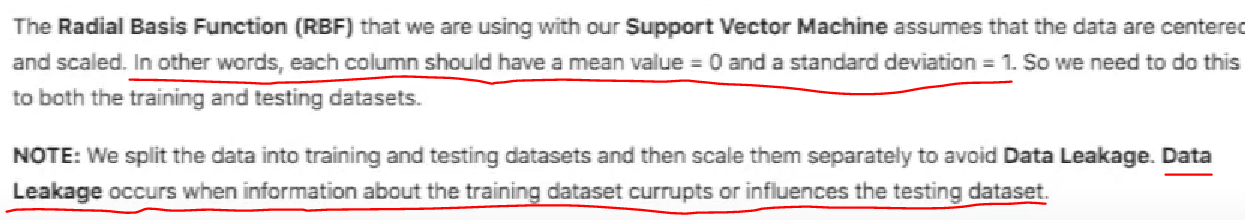

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

## BUILD A PRELIMINARY SUPPORT VECTOR MACHINE

In [26]:
clf_svm= SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

Lets check how the support vector machine performs on the Testing dataset and draw a Confusion matrix.

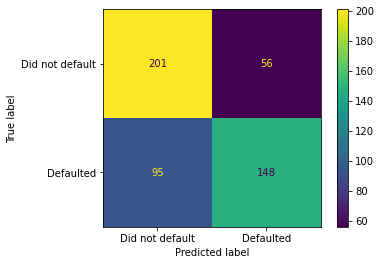

In [27]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, values_format='d', display_labels=['Did not default', 'Defaulted'])

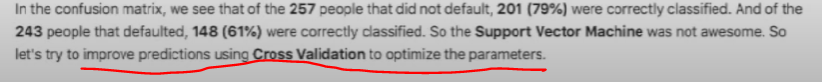

# Optimize parameters with Cross validation and GridSearchCV

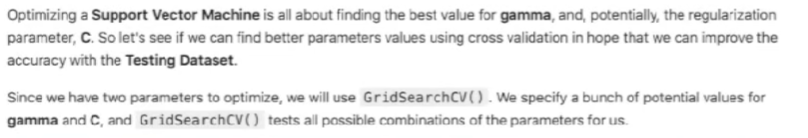

In [34]:
param_grid= [
    {'C': [0.5, 1, 10, 100], #Value sfor C must be more than zero.
'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
 'kernel': ['rbf']},
]
## C=1 and Gamma = scale are included here as possible choices since they are the default values.

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring= "accuracy",
    verbose=2
    
)

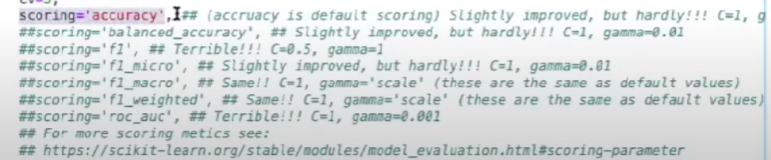

In [35]:
optimal_params.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.5, gamma=0.

[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.5, 1, 10, 100],
                          'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             scoring='accuracy', verbose=2)

In [38]:
print(optimal_params.best_params_)

# This is the ideal value for C and gamma after cross validation.

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


# Building, evaluating, drawing and interpreting the final support vector machine

No we have the ideal value of C and Gamma. Time to build the Support Vector machine.

In [39]:
clf_svm= SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

Now. let check the confusion matrix  values again.

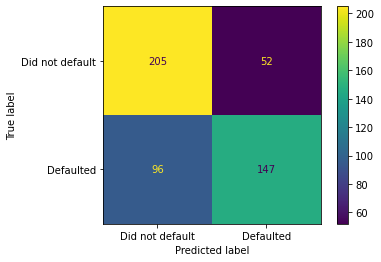

In [40]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, values_format='d', display_labels=['Did not default', 'Defaulted'])

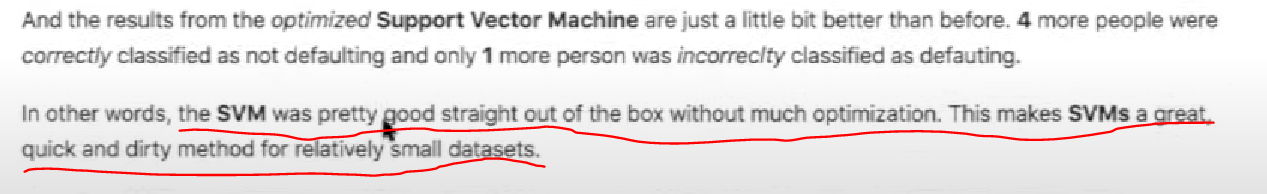

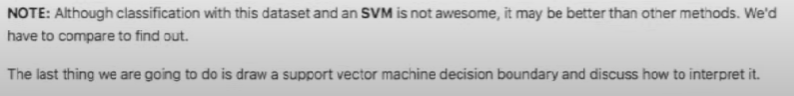

In [41]:
# Number of features

len(X.columns)

23

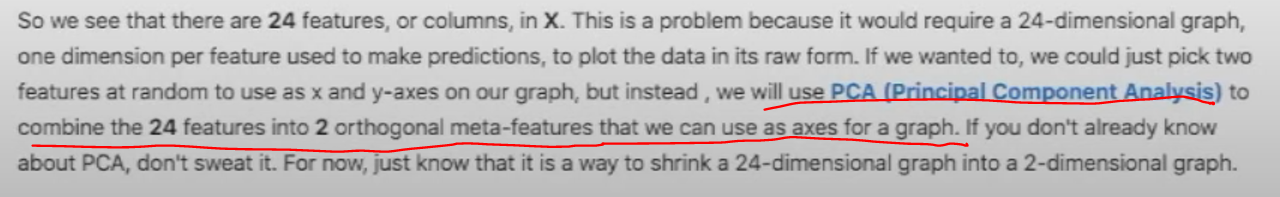

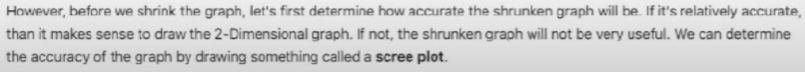

In [ ]:
pca = PCA() #Note: By default, PCA() centers the data but does not scale it.

X_train_pca = pca.fit_transform(X_train_scaled)

# The rest involves PCA so skipping for now.